## 인물모드 사진 만들기

### 학습 목표
- 의료영상 데이터를 처리하는 실습을 해본다.

### 루브릭 
-  의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다. : **모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.**
- 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다. : **regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.**
- 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다. : **Accuracy 기준 85%에 도달하였다.**

## 목차
### 1. 데이터 준비
### 2. CNN 모델링
### 3. 모델 훈련과 결과 확인
### 4. 모델/데이터 변형 실험
#### 1) 배치 정규화를 하지 않은 경우
#### 2) 드롭아웃을 적용하지 않은 경우
#### 3) 좌우반전 data augmentation을 적용하지 않은 경우
---

## 1. 데이터 준비

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [180, 180]

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 32
EPOCHS = 30

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)    # 리스트
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


* tf.io.gfile.glob(패턴): 주어진 패턴과 일치하는 파일 이름을 포함하는 문자열 리스트 호출

In [5]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


validation 데이터의 수가 너무 적어, 기존 validation과 test를 합친 다음 적당히 섞어서 8:2 비율로 다시 나누어 지정한다. 
* list.extend(iterable): 리스트 끝에 가장 바깥쪽 iterable의 모든 항목을 삽입
* math.floor(): 소수점 이하 버림
* math.ceil(): 소수점 이하 올림

In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


정상(NORMAL)과 폐렴(PENUMONIA) 데이터는 디렉토리 명으로 구분되어 있기 때문에, 파일의 경로를 나타내는 'filename'에서 "NORNAL"이 있는지 "PNEUMONUA"가 있는지 구분하여 train 데이터 내의 정상/폐렴 데이터의 수를 센다.

In [10]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

print(type(train_list_ds))

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validation images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validation images count: 1047


In [25]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


폐렴 이미지가 약 3배 정도 많은 imbalance 상태를 보완하기 위해 정상/폐렴 이미지 수에 반비례하는 가중치를 정의한다. 

In [11]:
# 이미지 라벨 구분
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # '파일 경로'를 기준으로 file_path를 나눔
    return parts[-2] == "PNEUMONIA"
    # '파일 경로'의 끝에서 두번째가 "PNEUMONIA"면 True, 아니면 False

In [12]:
# 이미지 형식 변경
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)    # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32)    # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE)    # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

In [13]:
# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어오기
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [14]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>


In [15]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [16]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(type(test_ds))
print(f"Test images count: {TEST_IMAGE_COUNT}")

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Test images count: 624


test 데이터에 같은 작업을 반복해 데이터셋을 완성한다.

In [17]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  
    return image,label

좌우 반전 augmentation. 폐 사진의 좌우 반전한 이미지를 생성하여 데이터 양을 늘린다.

In [18]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(augment, num_parallel_calls=2)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [22]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

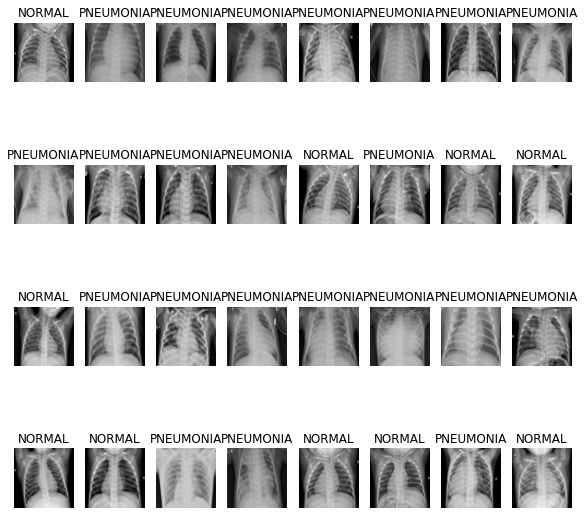

In [23]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 2. CNN 모델링

In [37]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

* tf.keras.layers.SeparableConv2D(): 각 입력 채널별로 컨볼루션을 수행한 다음 결과 출력 채널을 혼합. 
  * filters: 출력 공간의 차원(컨볼루션 출력 필터 수)
  * kernel_size: 필터의 높이와 너비
  * activation: 활성함수
  * padding: 패딩 적용 여부{'valid': 적용 안함, 'same':출력이 입력과 동일한 높이/너비를 갖도록 균등하게 패딩}
* tf.keras.layers.BatchNormalization(): 배치 정규화. 입력의 평균 출력을 0에 가깝게, 출력 표준 편차를 1에 가깝게 변환. 여러 계층을 지나는 동안의 내부 공변량 변화를 없애기 위해 계층에 대해 정규화를 진행한다. 
* tf.keras.layers.MaxPool2D(): 맥스풀링. 최댓값을 사용하는 요약 통계량 추출 연산.

In [38]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [39]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation = 'sigmoid')
        
    ])
    
    return model

## 3. 모델훈련과 결과 확인

In [29]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=METRICS)

In [30]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds, 
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE, 
        epochs = EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight    # imbalance 처리 반영
    )

Epoch 1/30
130/130 [==============================] - 85s 376ms/step - loss: 0.3906 - accuracy: 0.8154 - precision: 0.9590 - recall: 0.7854 - val_loss: 0.6052 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 2/30
130/130 [==============================] - 48s 373ms/step - loss: 0.2105 - accuracy: 0.9231 - precision: 0.9753 - recall: 0.9198 - val_loss: 0.8276 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/30
130/130 [==============================] - 49s 378ms/step - loss: 0.1679 - accuracy: 0.9394 - precision: 0.9791 - recall: 0.9386 - val_loss: 0.9671 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/30
130/130 [==============================] - 50s 388ms/step - loss: 0.1389 - accuracy: 0.9510 - precision: 0.9830 - recall: 0.9506 - val_loss: 1.3519 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 5/30
130/130 [==============================] - 53s 412ms/step - loss: 0.1458 - accura

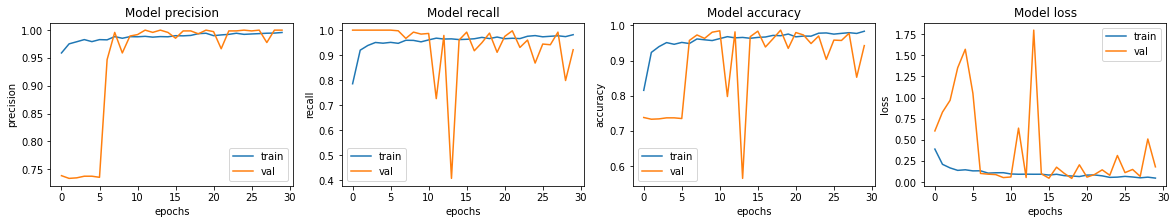

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [32]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 222ms/step - loss: 0.5686 - accuracy: 0.8558 - precision: 0.8363 - recall: 0.9564
Loss: 0.56862473487854,
Accuracy: 0.8557692170143127,
Precision: 0.8363228440284729,
Recall: 0.9564102292060852


최종 accuracy 85%는 달성했으나, epoch 진행에 따라 recall, accuracy, loss의 기복이 심하다.

모델의 정규화 기법 중, 배치 정규화는 신경망 계층을 통과하면서 추출된 특징에 노이즈를 넣는 효과가 나고 그럼으로써 모델이 복잡해질 수 있는 단점을 가지고 있다고 한다. 모델 중간에 드롭아웃을 적용함으로써 이미 가중치에 노이즈를 넣은 셈이 되기 때문에 일반적으로 배치 정규화와 드롭아웃을 동시에 적용하는 것이 잘 사용되지 않는 것으로 추정된다.

또한 배치 정규화는 내부 공변량 변화를 억제하기 위해 사용하는만큼, 활성화함수를 지난 다음 정규화를 적용하기보다는 활성화함수를 거치기 전 선형 연산 결과에 적용하는 것이 더 효율적이라고 알려져 있으나 본 모델은 이미 Convolution 레이어(tf.keras.layers.SeparableConv2D) 또는 Dense 레이어(tf.keras.layers.Dense)에서 활성화함수 'ReLU'를 적용한 다음 배치 정규화가 시행되고 있다. 따라서 배치 정규화를 삭제한 모델에서 성능 개선이 있는지 확인해보고자 한다.

[참고 블로그: Deep Learning with Writing](https://mole-starseeker.tistory.com/45)

## 4. 모델/데이터 변형 실험

### 1) 배치 정규화를 하지 않은 경우

In [40]:
def conv_block_2(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block_2(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [41]:
def build_model_2():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block_2(32),
        conv_block_2(64),
        
        conv_block_2(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block_2(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_2(512, 0.7),
        dense_block_2(128, 0.5),
        dense_block_2(64, 0.3),
        
        tf.keras.layers.Dense(1, activation = 'sigmoid')
        
    ])
    
    return model

In [42]:
with tf.device('/GPU:0'):
    model = build_model_2()
    
    METRICS = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=METRICS)

In [43]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds, 
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE, 
        epochs = EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight    # imbalance 처리 반영
    )

Epoch 1/30
130/130 [==============================] - 57s 371ms/step - loss: 0.9194 - accuracy: 0.4995 - precision: 0.7410 - recall: 0.5029 - val_loss: 0.6674 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 2/30
130/130 [==============================] - 47s 366ms/step - loss: 0.8016 - accuracy: 0.5046 - precision: 0.7465 - recall: 0.5055 - val_loss: 0.6629 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/30
130/130 [==============================] - 48s 371ms/step - loss: 0.7849 - accuracy: 0.4981 - precision: 0.7484 - recall: 0.4901 - val_loss: 0.6507 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/30
130/130 [==============================] - 48s 371ms/step - loss: 0.7449 - accuracy: 0.5026 - precision: 0.7440 - recall: 0.5071 - val_loss: 0.6785 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/30
130/130 [==============================] - 50s 384ms/step - loss: 0.7470 - accura

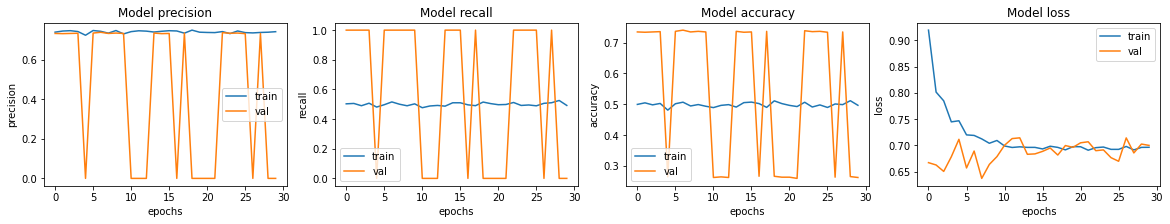

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [47]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 199ms/step - loss: 0.6969 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss: 0.6969058513641357,
Accuracy: 0.375,
Precision: 0.0,
Recall: 0.0


배치 정규화를 없애자 성능이 매우 떨어지는 ~돌팔이~ 모델이 탄생했다. 데이터 분포가 왜곡되는 현상을 막아주는 배치 정규화는 진단 모델에는 없어서는 안될 처리인 듯 하다. 이번에는 드롭아웃을 하지 않는 모델을 만들어 성능을 비교해본다.

### 2) 드롭아웃을 적용하지 않은 경우

In [44]:
def dense_block_3(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
    ])
    
    return block

In [52]:
def build_model_3():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        
        conv_block(256),
        
        tf.keras.layers.Flatten(),
        dense_block_3(512, 0.7),
        dense_block_3(128, 0.5),
        dense_block_3(64, 0.3),
        
        tf.keras.layers.Dense(1, activation = 'sigmoid')
        
    ])
    
    return model

In [53]:
with tf.device('/GPU:0'):
    model = build_model_3()
    
    METRICS = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=METRICS)

In [54]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds, 
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE, 
        epochs = EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight    # imbalance 처리 반영
    )

Epoch 1/30
130/130 [==============================] - 69s 409ms/step - loss: 0.2069 - accuracy: 0.9175 - precision: 0.9774 - recall: 0.9101 - val_loss: 0.5942 - val_accuracy: 0.7412 - val_precision: 0.7412 - val_recall: 1.0000
Epoch 2/30
130/130 [==============================] - 47s 363ms/step - loss: 0.1226 - accuracy: 0.9579 - precision: 0.9867 - recall: 0.9564 - val_loss: 0.8436 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/30
130/130 [==============================] - 48s 369ms/step - loss: 0.1040 - accuracy: 0.9601 - precision: 0.9877 - recall: 0.9584 - val_loss: 1.1520 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/30
130/130 [==============================] - 48s 372ms/step - loss: 0.1013 - accuracy: 0.9635 - precision: 0.9903 - recall: 0.9602 - val_loss: 1.3272 - val_accuracy: 0.7412 - val_precision: 0.7412 - val_recall: 1.0000
Epoch 5/30
130/130 [==============================] - 49s 378ms/step - loss: 0.0952 - accura

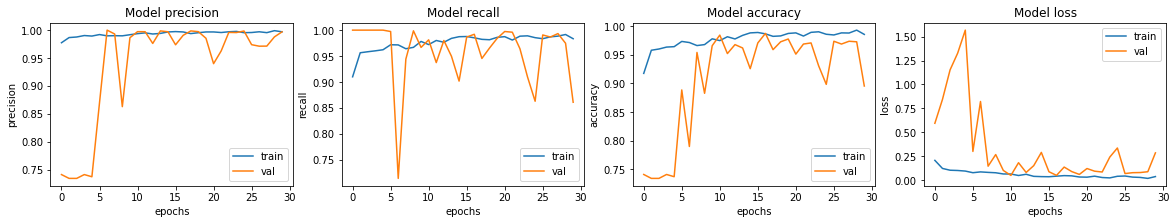

In [55]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [56]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 208ms/step - loss: 0.4012 - accuracy: 0.8590 - precision: 0.8852 - recall: 0.8897
Loss: 0.40117624402046204,
Accuracy: 0.8589743375778198,
Precision: 0.8852040767669678,
Recall: 0.8897435665130615


accuracy는 배치 정규화와 드롭아웃을 둘다 적용했을 때와 크게 달라지지 않았으나 recall이 떨어졌다. 병의 진단 모델이니만큼 평가 척도 중 recall이 중요하기 때문에, 첫번째 모델에 비해 성능이 좋아졌다고 보기 어렵다. validation 평가 척도들의 기복도 첫번째에 비해 심한데, train이 비교적 더 빠르게 loss를 줄이고 accuracy를 올리는 것으로 보아 첫번째 모델에 비해 과적합이 발생한 것으로 추정된다.

깊게 설계된 모델에서 배치 정규화는 모델 내에서 이미지가 계층을 통과할 수록 높아지는 데이터 왜곡에 대한 위험을 방지해준다면, 드롭아웃은 훈련데이터에 대한 과적합을 막을 수 있도록 모델 내에서 변화를 주는 측면에서 필요한 듯 하다.

### 3) 좌우반전 data augmentation을 적용하지 않은 경우
위 단계에서 가장 성능이 좋았던 첫번째 모델(배치 정규화와 드롭아웃을 둘다 적용한 모델)을 좌우반전 data augmentation을 적용하지 않은 train, validation 데이터로 학습시켜본다.

In [57]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [58]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

데이터를 다시 불러오되, 전처리 함수에서 좌우반전 augmentation을 생략하고 적용한다.

In [60]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=METRICS)

In [61]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds, 
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE, 
        epochs = EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight    # imbalance 처리 반영
    )

Epoch 1/30
130/130 [==============================] - 57s 370ms/step - loss: 0.3845 - accuracy: 0.7945 - precision: 0.9575 - recall: 0.7572 - val_loss: 0.5879 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 2/30
130/130 [==============================] - 47s 359ms/step - loss: 0.1966 - accuracy: 0.9257 - precision: 0.9790 - recall: 0.9198 - val_loss: 0.8196 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/30
130/130 [==============================] - 47s 365ms/step - loss: 0.1576 - accuracy: 0.9406 - precision: 0.9821 - recall: 0.9374 - val_loss: 1.0316 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 4/30
130/130 [==============================] - 47s 363ms/step - loss: 0.1482 - accuracy: 0.9498 - precision: 0.9829 - recall: 0.9489 - val_loss: 1.5503 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/30
130/130 [==============================] - 49s 375ms/step - loss: 0.1246 - accura

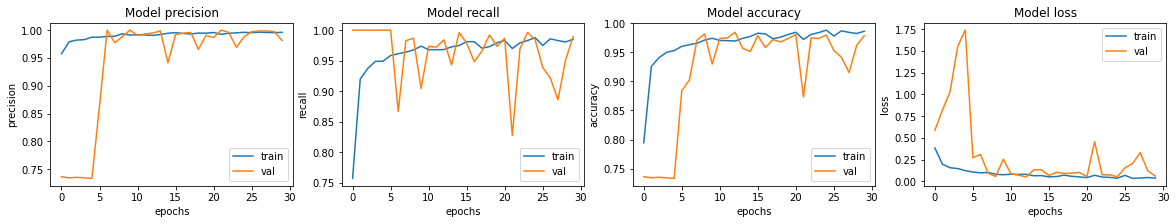

In [62]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [63]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 183ms/step - loss: 1.3229 - accuracy: 0.7756 - precision: 0.7395 - recall: 0.9897
Loss: 1.3229336738586426,
Accuracy: 0.7756410241127014,
Precision: 0.7394636273384094,
Recall: 0.9897435903549194


data augmentation을 생략했을 때 accuracy와 precision은 떨어지고 recall은 조금 올랐다. 폐렴 데이터가 정상 데이터에 비해 불균형하게 많은 상태를 보정하기 위해 가중치를 조절했지만, 전체 데이터의 수가 적으면 보정의 효과가 떨어져 모델이 폐렴으로 진단내릴 확률이 필요 이상으로 높아진 것이 아닐까 짐작된다.

## 회고

* 이번 exp는 '데이터가 딥러닝 학습을 진행할만큼 충분히 많지 않을 때' 모델의 과적합을 방지하기 위해 정규화 기법들에 대해 전체적으로 다루어보았다. 이번 케이스를 가지고 일반화하기는 어렵겠지만, 배치 정규화와 드롭아웃은 각각 다른 문제를 보정하는 기술인 것으로 보인다. 두 기법을 동시에 사용하는 것이 일반적으로 금기시 되어있는 이유가 무엇인지 좀 더 알아보고 싶어졌다.
* data augmentation을 통해 생성한 데이터가 원본 데이터와 충분히 비슷한지 검증하는(예를 들어 숫자 '6'을 여러 각도로 회전하여 augmentation 하면 '9'와 헷갈릴 수도 있는데, 그것을 방지하는) 단계는 없을지 궁금하다. 검증 단계를 따로 설계하는 것이 너무 복잡하거나 사람의 개입이 지나치게 많이 필요하다면 훈련 데이터의 레이블에 오차가 있을 경우를 보정하는 'label smoothing' 방법을 함께 써주는 것이 꼭 필요하지 않을까.
* 데이터 로드 시에 사용한 설정 변수 'AUTOTUNE' 사용 방법이 잘 와닿지 않는다. csv 파일처럼 하나의 파일에서 데이터를 가공하는 상황이 아닌만큼 파일 경로를 일일이 이용하는 것에 비해 데이터 준비 과정을 편하게 해주는 도구인 것 같은데, 복습이 더 필요하다..